# GRE processing pipeline
This notebook presents the image pre-processing and single-acquistion electrical properties (SAEP) tools used for reconstructing conductivity ($\sigma$) and permittivity ($\epsilon_r$) from multi-channel GRE reference scans, demonstrated on a example subject from the dHCP cohort.

**Acquisition information:** Imaging was carried out on a 3T ($f_0 = 128$ MHz) Philips Achieva scanner. Low resolution ($2.6$ mm isotropic) GRE scans were acquired for parallel imaging sensitivity calibration as part of the dHCP protocol, including data from each of the $32$ channels in the array head coil, plus an additional body coil reference.

Part of nano-eptk package by Arnaud Boutillon (arnaud.boutillon@kcl.ac.uk).

## Python environment setting

In [1]:
import os
import sys
import json
import yaml
import itertools

base_dir = os.path.abspath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(os.path.join(base_dir))

from utils.eprecon import *
from utils.preprocess import *
from utils.tools import *
from utils.plots import *

## 1. Image pre-processing

### 1.a. Gibbs artefacts correction
Gibbs ringing artefacts were removed from the low-resolution multi-channel complex GRE images using the complex-valued 3D sub-voxel shifts technique of MRtrix.

In [2]:
# Set directories
subj_dir = os.path.join(base_dir, "data", "dHCP", "example_subject")
gre_dir = os.path.join(subj_dir, "GRE")
deriv_dir = os.path.join(gre_dir, "derivatives")

# Set file path
mag_path = os.path.join(gre_dir, "mag.nii.gz")
pha_path = os.path.join(gre_dir,  "pha.nii.gz")
mag_degibbs_path = os.path.join(deriv_dir, "mag_degibbs.nii.gz")
pha_degibbs_path = os.path.join(deriv_dir, "pha_degibbs.nii.gz")

# Run DeGibbs correction
degibbs(
    input_mag_path=mag_path, 
    input_pha_path=pha_path,
    output_mag_path=mag_degibbs_path, 
    output_pha_path=pha_degibbs_path,
    k_window=[6, 90, 7, 90, 24, 72],
)

### 1.b. Reference coil extraction
The body coil was used for registration and normalization purposes.

In [3]:
# Set file path
mag_ref_path = os.path.join(deriv_dir, "mag_ref.nii.gz")

# Extract reference coil
extract_reference_coil(
    input_mag_path=mag_degibbs_path,
    output_mag_path=mag_ref_path,
    ref_coil_idx=32,
)

### 1.c. Registration of GRE scan to T2w volume
Images were rigdly aligned using MIRTK. We registered available dHCP tissue segmentation to define the brain region of interest (ROI) for conductivity reconstruction in GRE data.

In [4]:
# Set directories
tse_dir = os.path.join(subj_dir, "TSE")
T1w_path = os.path.join(tse_dir, "T1w.nii.gz")
dof_path = os.path.join(deriv_dir, "GRE_T1w.dof")

# Set file path
T1w_mask_path = os.path.join(tse_dir, "mask.nii.gz")
T1w_dhcp_labels9_path = os.path.join(tse_dir, "dhcp_labels9.nii.gz")
mask_path = os.path.join(deriv_dir, "mask.nii.gz")
dhcp_labels9_path = os.path.join(deriv_dir, "dhcp_labels9.nii.gz")

# Register GRE to volume
mirtk_register(
    input_img1_path=T1w_path,
    input_img2_path=mag_ref_path,
    output_dof_path=dof_path,
)

# Apply transform to mask and volume
mirtk_transform_image(
    input_path=T1w_mask_path,
    input_target_path=mag_ref_path,
    input_invdof_path=dof_path,
    output_path=mask_path,
    label=True,
)
mirtk_transform_image(
    input_path=T1w_dhcp_labels9_path,
    input_target_path=mag_ref_path,
    input_invdof_path=dof_path,
    output_path=dhcp_labels9_path,
    label=True,
)

## 2. Electrical properties reconstruction from GRE data

### 2.a. Brain conductivity and permittivity reconstruction using the single-acquisition electrical properties (SAEP) pipeline
The $\sigma$ and $\epsilon_r$ were reconstructed inside the brain ROI mask using the SAEP method based on the homogeneous Helmholtz equation. The SAEP method relies on the local homogeneity assumption which states that the EPs are piecewise constant functions. The spatial derivatives were computed using central difference schemes on the image grid and the inverse problem was solved by Moore-Penrose matrix inversion at each spatial location (i.e. voxel). Prior to reconstruction, the complex-valued signal of each channel was smoothed via an isotropic 3D Gaussian filter. We applied singular value decomposition (SVD) based channel compression to reduce the number of channels. The predicted EPs maps were eroded using binary erosion to remove spurious oscillation at brain boundaries 

**Pipeline parameters:** Gaussian smoothing STD kernel $3.9$ mm, $12$ modes SVD truncation, erosion radius $15.6$ mm.

In [5]:
# Set directories
ep_saep_dir = os.path.join(gre_dir, "ep_recon_saep")
deriv_saep_dir = os.path.join(gre_dir, "derivatives_saep")
config_dir = os.path.join(base_dir, "config")

# Set file path
sig_path = os.path.join(ep_saep_dir, "sig.nii.gz")
eps_path = os.path.join(ep_saep_dir, "eps.nii.gz")
ep_metrics_path = os.path.join(ep_saep_dir, "ep_metrics.json")
mask_eroded_path = os.path.join(deriv_saep_dir, "mask_eroded.nii.gz")
sig_eroded_path = os.path.join(ep_saep_dir, "sig_eroded.nii.gz")
eps_eroded_path = os.path.join(ep_saep_dir, "eps_eroded.nii.gz")
config_path = os.path.join(config_dir, "dhcp_gre_saep.yaml")

# Load pipeline configuration
kwargs = yaml.safe_load(open(config_path))

# Run SAEP pipeline
saep_pipeline(
    input_mag_path=mag_degibbs_path,
    input_pha_path=pha_degibbs_path,
    input_mask_path=mask_path,
    input_dhcp_labels9_path=dhcp_labels9_path,
    output_sig_path=sig_path,
    output_eps_path=eps_path,
    output_ep_metrics_path=ep_metrics_path,
    output_mask_eroded_path=mask_eroded_path,
    output_sig_eroded_path=sig_eroded_path,
    output_eps_eroded_path=eps_eroded_path,
    **kwargs,
)

#### Conductivity and permittivity results

In [6]:
# Load EPs metrics
ep_metrics = json.load(open(ep_metrics_path))

# Display metrics
print("GRE SAEP reconstruction pipeline results:")
print(f"ROI conductivity: {ep_metrics['SIG']:.2f} ± {ep_metrics['SIG_std']:.2f} [S.m⁻¹]")
print(f"Brain conductivity (excluding CSF and ventricles): {ep_metrics['brain_SIG']:.2f} ± {ep_metrics['brain_SIG_std']:.2f} [S.m⁻¹]")
print(f"dGM conductivity: {ep_metrics['dGM_SIG']:.2f} ± {ep_metrics['dGM_SIG_std']:.2f} [S.m⁻¹]")
print(f"WM conductivity: {ep_metrics['WM_SIG']:.2f} ± {ep_metrics['WM_SIG_std']:.2f} [S.m⁻¹]\n")

print(f"ROI permittivity: {ep_metrics['EPS']:.2f} ± {ep_metrics['EPS_std']:.2f}")
print(f"Brain permittivity (excluding CSF and ventricles): {ep_metrics['brain_EPS']:.2f} ± {ep_metrics['brain_EPS_std']:.2f}")
print(f"dGM permittivity: {ep_metrics['dGM_EPS']:.2f} ± {ep_metrics['dGM_EPS_std']:.2f}")
print(f"WM permittivity: {ep_metrics['WM_EPS']:.2f} ± {ep_metrics['WM_EPS_std']:.2f}")

GRE SAEP reconstruction pipeline results:
ROI conductivity: 1.13 ± 0.62 [S.m⁻¹]
Brain conductivity (excluding CSF and ventricles): 1.14 ± 0.62 [S.m⁻¹]
dGM conductivity: 1.28 ± 0.60 [S.m⁻¹]
WM conductivity: 1.08 ± 0.56 [S.m⁻¹]

ROI permittivity: 68.93 ± 110.31
Brain permittivity (excluding CSF and ventricles): 76.47 ± 107.62
dGM permittivity: 82.51 ± 114.04
WM permittivity: 55.43 ± 97.20


#### Diagram representation of the GRE SAEP pipeline
The SAEP method leads to spurious oscillations in the reconstructed conductivity at the tissue interface (i.e. where the homogeneity assumption is violated).

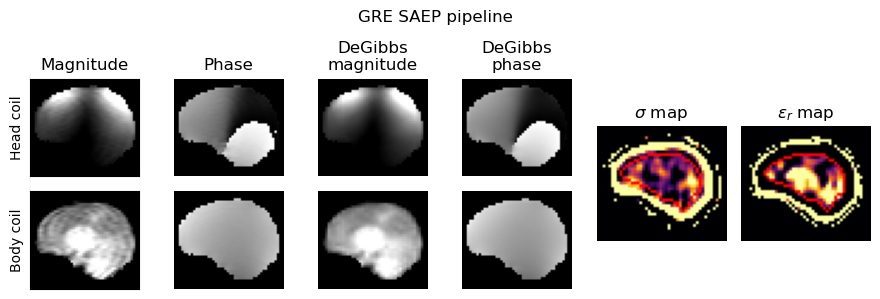

In [7]:
# Set file path
plot_dir = os.path.join(base_dir, "plots", "processing_pipelines")
plot_path = os.path.join(plot_dir, "gre_saep.png")

# Plotting
gre_pipeline_plot(
    input_mag_path=mag_path,
    input_pha_path=pha_path,
    input_mag_degibbs_path=mag_degibbs_path,
    input_pha_degibbs_path=pha_degibbs_path,
    input_sig_path=sig_path,
    input_eps_path=eps_path,
    input_mask_path=mask_path,
    input_mask_eroded_path=mask_eroded_path,
    output_plot_path=plot_path,
    slice_index=45,
    ornt="sagittal",
    view_info={"head": {"img_index": 0}, "body": {"img_index": 32}},
    xlim=[25, -30],
    ylim=[25, -25],
    pha_clim=[-np.pi, np.pi],
    sig_clim=[0.6, 2.2],
    eps_clim=[10, 200],
    sig_cmap="inferno",
    eps_cmap="inferno",
    outline_c=(1,0,0),
    figsize=(9,3),
    title="GRE SAEP pipeline",
    save_imageio=True,
)

## 3. Impact of SAEP pipeline parameters on electrical properties reconstruction

### 3.a Tuning of Gaussian smoothing (*$\Sigma$*) and number of SVD modes truncated (*$n_{SVD}$*)
Smoothing is a typical pre-processing step in all EPT pipelines to improve the robustness of the EPs reconstruction, as derivatives involved in Helmholtz equation are very sensitive to noise in the high frequency region of the Fourier spectrum. However, this also exacerbates boundary errors; therefore, there is a trade-off between signal to noise ratio (SNR) and tissue contrast in EPs maps. By truncating the low-rank SVD modes, we were able to lessen the noise present in the revelative sensitivities and lower the number of linear equations to be solved in the inverse problem, thus slightly reducing computational time.  

In [8]:
# Set directory
tuning_dir = os.path.join(gre_dir, "ep_recon_saep_tuning")

# Set parameters grid
gs_sigmas = [0.65, 1.3, 1.95, 2.6, 3.25]
n_svds = [4, 12, 20]
sig_paths = []
eps_paths = []

# Iter over parameters
for i, (gs_sigma, n_svd) in enumerate(itertools.product(gs_sigmas, n_svds)):
    # Set file path
    sig_path = os.path.join(tuning_dir, f"sig_{i}.nii.gz")
    eps_path = os.path.join(tuning_dir, f"eps_{i}.nii.gz")
    sig_paths += [sig_path]
    eps_paths += [eps_path]

    # Set parameters
    kwargs = yaml.safe_load(open(config_path))
    kwargs["gs_sigma"] = gs_sigma
    kwargs["n_svd"] = n_svd

    # Run POCR pipeline
    saep_pipeline(
        input_mag_path=mag_degibbs_path,
        input_pha_path=pha_degibbs_path,
        input_mask_path=mask_path,
        output_sig_path=sig_path,
        output_eps_path=eps_path,
        **kwargs,
    )

# Reshape arrays
m, k = len(gs_sigmas), len(n_svds)
sig_paths = [sig_paths[i*k:(i+1)*k] for i in range(m)]
eps_paths = [eps_paths[i*k:(i+1)*k] for i in range(m)]

#### Parameter tuning plot

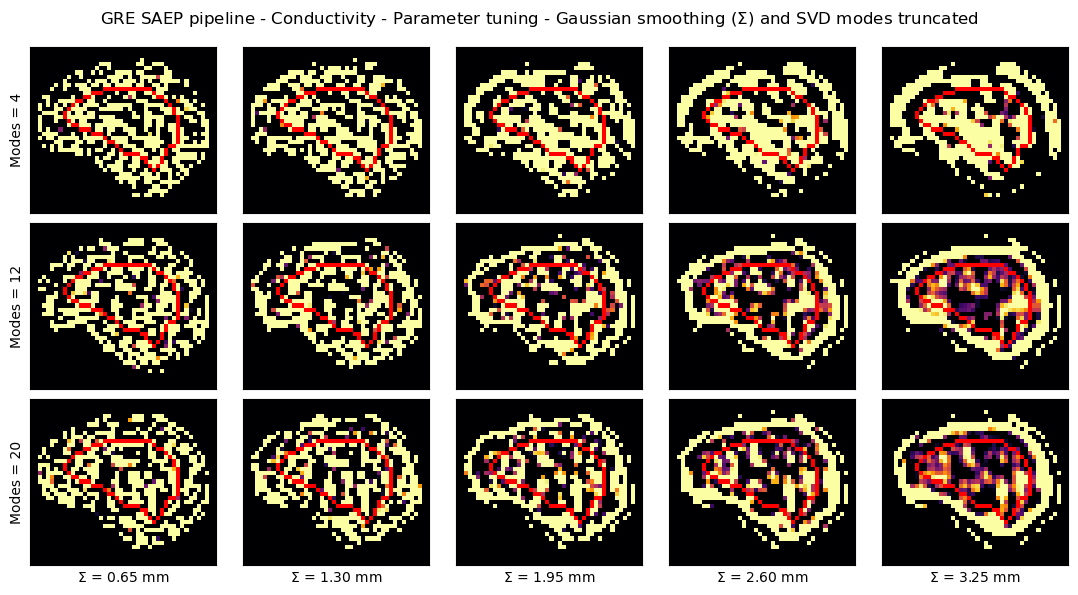

In [9]:
# Set file path
plot_path = os.path.join(plot_dir, "gre_saep_tuning_sig.png")
gs_sigma_labels = [f"{gs_sigma:.2f} mm" for gs_sigma in gs_sigmas]

# Plotting
parameter_tuning_plot(
    input_sig_paths=sig_paths,
    input_mask_path=mask_path,
    input_mask_eroded_path=mask_eroded_path,
    output_plot_path=plot_path,
    slice_index=45,
    ornt="sagittal",
    xlim=[25, -30],
    ylim=[25, -25],
    param_info={r"$\sigma$": gs_sigma_labels, "Modes": n_svds},
    ep_clim=[0.6, 2.2],
    ep_cmap="inferno",
    outline_c=(1,0,0),
    figsize=(11, 6),
    title=r"GRE SAEP pipeline - Conductivity - Parameter tuning - Gaussian smoothing ($\Sigma$) and SVD modes truncated",
    save_imageio=True,
)

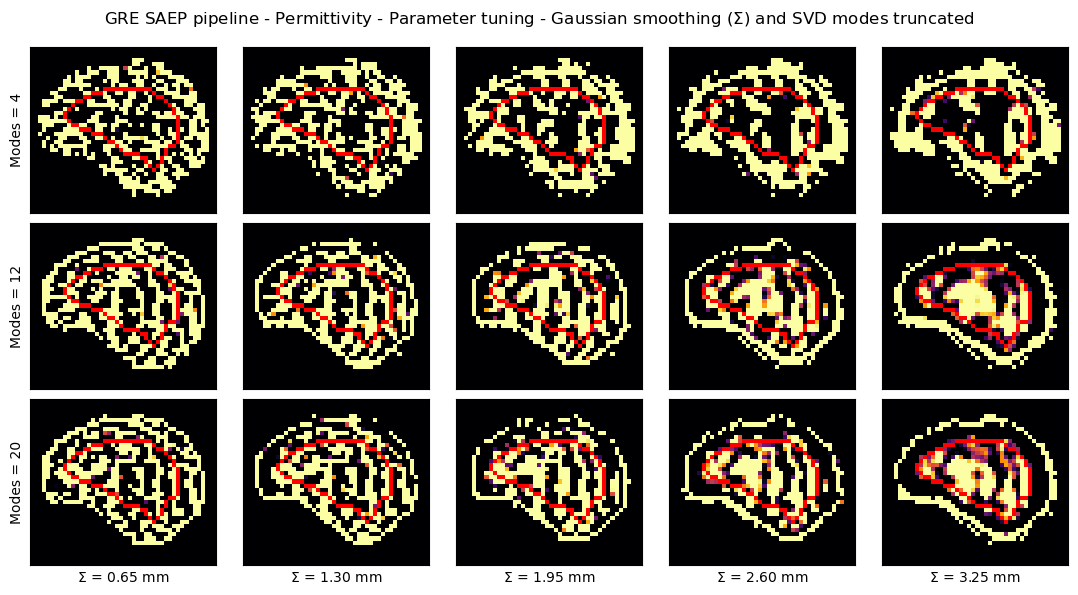

In [10]:
# Set file path
plot_path = os.path.join(plot_dir, "gre_saep_tuning_eps.png")

# Plotting
parameter_tuning_plot(
    input_sig_paths=eps_paths,
    input_mask_path=mask_path,
    input_mask_eroded_path=mask_eroded_path,
    output_plot_path=plot_path,
    slice_index=45,
    ornt="sagittal",
    xlim=[25, -30],
    ylim=[25, -25],
    param_info={r"$\sigma$": gs_sigma_labels, "Modes": n_svds},
    ep_clim=[10, 200],
    ep_cmap="inferno",
    outline_c=(1,0,0),
    figsize=(11, 6),
    title=r"GRE SAEP pipeline - Permittivity - Parameter tuning - Gaussian smoothing ($\Sigma$) and SVD modes truncated",
    save_imageio=True,
)